# Getting started

`BGLS` is a Python package that implements the Bravyi, Gosset, and Liu Sampling algorithm presented in *How to simulate quantum measurement without computing marginals ([Phys. Rev. Lett.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.128.220503)) ([arXiv](https://arxiv.org/abs/2112.08499))*.

## Quick start

Install `BGLS` via `pip install bgls`. The following example shows how to use the package.

In [1]:
"""Setup."""
import cirq

import bgls

In [2]:
"""Define a circuit."""
nqubits = 2
qubits = cirq.LineQubit.range(nqubits)

circuit = cirq.Circuit(
    cirq.H.on(qubits[0]),
    cirq.CNOT.on(qubits[0], qubits[1]),
    cirq.measure(*qubits, key="z")
)
circuit

0: ───H───@───M('z')───
          │   │
1: ───────X───M────────

/home/ryan/prof/work/bgls/envbgls/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


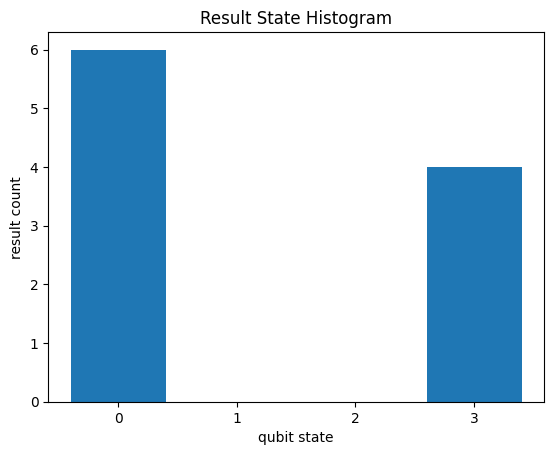

In [3]:
"""Use BGLS to simulate the circuit."""
simulator = bgls.Simulator(
    initial_state=cirq.StateVectorSimulationState(qubits=qubits, initial_state=0),
    apply_gate=cirq.protocols.act_on,
    compute_probability=bgls.utils.cirq_state_vector_bitstring_probability,
)
results = simulator.run(circuit, repetitions=10)

cirq.plot_state_histogram(results);

## More detail: How to create a `bgls.Simulator`

Notice from the above example that there are three ingredients needed to create a `bgls.Simulator`:

1. `initial_state`: The initial quantum state (wavefunction) of the circuit, including what type the wavefunction is (state vector, density matrix, tensor network, etc.).
1. `apply_gate`: A function for applying gates to the initial (and intermediate) states.
1. `compute_probability`: A function for calculating the probability of sampling a bitstring from the input state type.

> **Note**: A function to compute marginal distributions, which is used in the typical "qubit-by-qubit" sampling algorithm, is not needed. This is the primary purpose of the BGLS "gate-by-gate" sampling algorithm: when it is easier to compute probabilities than it is to compute marginal distributions, the BGLS algorithm is advantageous to use. See more on [How `BGLS` works](./how_it_works.ipynb) and [When to use BGLS]().

Any wavefunction type can be used with `BGLS`. In the example above, we used a `cirq.StateVectorSimulationState` which represents the wavefunction as a state vector.

In [4]:
"""Provide a representation of the (initial) wavefunction, here a cirq.StateVectorSimulationState."""
wavefunction = cirq.StateVectorSimulationState(qubits=qubits, initial_state=0)

# Visualize the wavefunction.
wavefunction.target_tensor.reshape(2 ** nqubits)

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], dtype=complex64)

Once the state is provided, `BGLS` needs to know how to apply gates to the state. Here, we can do this with `cirq.protocols.act_on`.

In [5]:
"""Define a function for applying operations to the state."""
from typing import Any


def apply_gate(operation: cirq.GateOperation, state: cirq.StateVectorSimulationState) -> None:
    cirq.protocols.act_on(operation, state)


# Example: Apply operation and visualize the updated wavefunction.
apply_gate(cirq.H.on(qubits[0]), wavefunction)
wavefunction.target_tensor.reshape(2 ** nqubits).round(3)

array([ 0.707+0.j,  0.   +0.j,  0.707+0.j, -0.   +0.j], dtype=complex64)

> Note: The `apply_gate` function can modify the `state` in-place (as above) or return a copy.

Last, `BGLS` needs to know how to compute the probability of sampling a bitstring `z` from the `wavefunction` $|\psi\rangle$. Here this is given by $| \langle z | \psi \rangle | ^ 2$ and can be computed via the following function.

In [6]:
"""Define a function for computing the probability of sampling a bitstring."""
import numpy as np


def probability_of_bitstring(
    wavefunction: cirq.StateVectorSimulationState,
    bitstring: str,
) -> float:
    return np.abs(wavefunction.target_tensor.reshape(2 ** nqubits)[int(bitstring, 2)]) ** 2


# Example: Calculating some p(z) for some bitstrings z.
for bitstring in {"00", "10"}:
    print(f"Probability of sampling {bitstring} is {probability_of_bitstring(wavefunction, bitstring):.2f}")

Probability of sampling 00 is 0.50
Probability of sampling 10 is 0.50


> Note: This function is identical to `bgls.utils.cirq_state_vector_bitstring_probability` used in the Quick start example.

With these three ingredients you can create a `bgls.Simulator` and execute circuits with `bgls.Simulator.run`.

In [7]:
simulator = bgls.Simulator(wavefunction, apply_gate, probability_of_bitstring)

simulator.run(circuit)

z=0, 0

## When to use the `bgls.Simulator`

Other than introducing the `bgls.Simulator`, there's (probably) no good reason to use `BGLS` with a statevector simulator as above: the samples can be drawn from the final state just as easily. The power of the `bgls.Simulator` comes in situations where it is easier to compute probabilities than compute marginal distributions - see [When to use `BGLS`]() for more discussion and examples.